In [1]:
# Import libraries
import pickle
import http.client, urllib.parse
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import fastai.tabular.all as fastai
np.set_printoptions(linewidth=130)
import torch
import json

load_dotenv()
key = os.getenv('API_KEY')

# longLats pickle
def load_pkl():
  longLats = pickle.load(open('./longLat.pkl', 'rb'))
  print(f"longLats loaded. {len(longLats)}")
  return longLats
def dump_pkl(longLats):
    pickle.dump(longLats, open('./longLat.pkl', 'wb'))
    print(f"pickle dumped. {len(longLats)}")
longLats = load_pkl()

# clean up data: area, date, floor, price
def load_csv():
  #return pd.read_csv('./data/Woodlands_June22_May23.csv')
  return pd.read_csv('./data/resale-flat-from-jan-2017.csv')
floor_dict = { f'0{i*3+1} TO 0{i*3+3}' if i < 3 else f'{i*3+1} TO {i*3+3}': i*3+2  for i in range(17)  }
def floor_cleanup(df):
  df['floor'] = df.storey_range.apply(lambda x:float(floor_dict[x]) if isinstance(x,str) else x)
  df.drop(['storey_range'], axis=1, inplace=True)
  return df
date_dict = { f'20{17+i}-0{j+1}' if j < 9 else f'20{17+i}-{j+1}': i*12+j  for i in range(7) for j in range(12)  }
def date_cleanup(df):
  df['date'] = df.month.apply(lambda x:float(date_dict[x]) if isinstance(x,str) else x)
  df.drop(['month'], axis=1, inplace=True)
  return df
def load_and_cleanup():
  df = load_csv()
  df = floor_cleanup(df)
  df = date_cleanup(df)
  return df

df = load_and_cleanup()
df.describe()
date_max = df.date.max()
town = 'Punggol'
df = df[(df.town==town.replace('_', ' ').upper()) & (df.date > date_max-12)]
from pathlib import Path
file = Path(f'./data/{town}_June22_May23.csv')
df.to_csv(file,index=False)
df


longLats loaded. 6733


,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,floor,date
128844,PUNGGOL,2 ROOM,672C,EDGEFIELD PLAINS,44.0,Model A,2015,92 years 07 months,280000.0,5.0,65.0
128845,PUNGGOL,2 ROOM,672A,EDGEFIELD PLAINS,44.0,Model A,2015,92 years 07 months,310000.0,5.0,65.0
128846,PUNGGOL,2 ROOM,222A,SUMANG LANE,48.0,Model A,2018,95 years 06 months,320000.0,8.0,65.0
128847,PUNGGOL,3 ROOM,662A,EDGEDALE PLAINS,67.0,Premium Apartment,2017,94 years,450000.0,14.0,65.0
128848,PUNGGOL,3 ROOM,662B,EDGEDALE PLAINS,67.0,Premium Apartment,2017,94 years,410000.0,8.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...
153322,PUNGGOL,5 ROOM,226B,SUMANG LANE,114.0,Premium Apartment,2018,93 years 11 months,772000.0,17.0,76.0
153323,PUNGGOL,5 ROOM,234B,SUMANG LANE,113.0,Improved,2018,94 years 07 months,720000.0,11.0,76.0
153324,PUNGGOL,5 ROOM,322A,SUMANG WALK,113.0,Premium Apartment,2019,94 years 11 months,840000.0,14.0,76.0
153325,PUNGGOL,EXECUTIVE,182,EDGEFIELD PLAINS,128.0,Premium Apartment,2003,79 years 07 months,718688.0,11.0,76.0


In [2]:
blk_street = df.block + ' ' + df.street_name

longLats = load_pkl()
responses = []
errors = []
count = 0

conn = http.client.HTTPConnection('api.positionstack.com')
for i,add in enumerate(blk_street.unique()):
    params = urllib.parse.urlencode({
        'access_key': key,
        'query': add,
        'region': 'Singapore',
        'limit': 1,
    })
    conn.request('GET', '/v1/forward?{}'.format(params))
    res = conn.getresponse()
    data = res.read()
    dataList = json.loads(data.decode('utf-8'))['data']
    if (len(dataList)==0): 
      print(f"check {add}. No data returned")
      count += 1
      errors.append(add)
      continue
    first_response = dataList[0]
    responses.append(first_response)
    if (first_response['confidence'] > 0.9) and (first_response['country']=='Singapore'):
      longLats[f"{add}"] = (first_response['longitude'], first_response['latitude'])
      if (i%10==0): print(f"{i} of {len(blk_street.unique())}")
    else:
      print(f"check {add}. {first_response['label']}. confidence of {first_response['confidence']}")
      count += 1
      errors.append(add)

print(f"{count} errors detected")
dump_pkl(longLats)


longLats loaded. 6734
0 of 438
10 of 438
20 of 438
30 of 438
40 of 438
50 of 438
60 of 438
70 of 438
80 of 438
90 of 438
100 of 438
110 of 438
120 of 438
130 of 438
140 of 438
150 of 438
160 of 438
170 of 438
180 of 438
190 of 438
200 of 438
210 of 438
220 of 438
230 of 438
240 of 438
250 of 438
260 of 438
270 of 438
280 of 438
290 of 438
300 of 438
310 of 438
320 of 438
330 of 438
340 of 438
350 of 438
360 of 438
370 of 438
380 of 438
390 of 438
400 of 438
410 of 438
420 of 438
430 of 438
0 errors detected
pickle dumped. 7172


In [7]:
df[(df.street_name=='JLN BATU')|(df.street_name=='JLN BAHAGIA')|(df.street_name=='JLN TENTERAM')|(df.street_name=='')]
df.describe()

447

In [3]:
import math

def lat_long(df):
  adds = (df.block + ' ' + df.street_name)
  longLat = adds.apply(lambda x: longLats[x] if x in longLats else (math.nan, math.nan))
  df['long'] = longLat.apply(lambda x: x[0])
  df['lat'] = longLat.apply(lambda x: x[1])
  return df
lat_long(df)
df.describe()



,floor_area_sqm,lease_commence_date,resale_price,floor,date,long,lat
count,2051.000000,2051.000000,2.051000e+03,2051.000000,2051.000000,2051.000000,2051.000000
mean,94.528523,2012.923940,5.777164e+05,9.538762,70.538762,103.905422,1.401692
std,16.914867,5.418943,1.066240e+05,4.688214,3.399402,0.007683,0.004330
min,37.000000,2002.000000,2.800000e+05,2.000000,65.000000,103.890646,1.392108
25%,92.000000,2012.000000,5.200000e+05,5.000000,68.000000,103.899225,1.398540
50%,93.000000,2015.000000,5.700000e+05,11.000000,71.000000,103.907181,1.401683
75%,110.000000,2017.000000,6.350000e+05,14.000000,74.000000,103.911554,1.404182
max,149.000000,2019.000000,1.220000e+06,20.000000,76.000000,103.919175,1.412661


In [41]:
#df = pd.read_csv('./data/Kallang_Whampoa_June22_May23.csv')
df = df[~df.long.isna()].copy()
file = Path(f'./data/{town2}_June22_May23_without_newest.csv')
df.to_csv(file,index=False)
df

,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,floor,date,long,lat
1,KALLANG/WHAMPOA,3 ROOM,10A,BENDEMEER RD,68.0,Model A,2017,94 years 07 months,688000.0,35.0,65.0,103.860290,1.315576
2,KALLANG/WHAMPOA,3 ROOM,10C,BENDEMEER RD,68.0,Model A,2017,94 years 07 months,692000.0,32.0,65.0,103.860290,1.315576
3,KALLANG/WHAMPOA,3 ROOM,10A,BENDEMEER RD,68.0,Model A,2017,94 years 07 months,696000.0,23.0,65.0,103.860290,1.315576
4,KALLANG/WHAMPOA,3 ROOM,73,GEYLANG BAHRU,59.0,Improved,1974,50 years 10 months,350000.0,11.0,65.0,103.870707,1.322627
5,KALLANG/WHAMPOA,3 ROOM,73,GEYLANG BAHRU,59.0,Improved,1974,50 years 10 months,320000.0,5.0,65.0,103.870707,1.322627
...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,KALLANG/WHAMPOA,5 ROOM,106,TOWNER RD,138.0,Model A-Maisonette,1983,59 years 02 months,865000.0,2.0,76.0,103.861031,1.321032
858,KALLANG/WHAMPOA,5 ROOM,3A,UPP BOON KENG RD,110.0,Improved,2006,82 years 06 months,920000.0,8.0,76.0,103.872473,1.313947
859,KALLANG/WHAMPOA,5 ROOM,14A,UPP BOON KENG RD,122.0,Improved,1999,75 years 02 months,900000.0,8.0,76.0,103.870564,1.315384
860,KALLANG/WHAMPOA,5 ROOM,14,UPP BOON KENG RD,120.0,Improved,1999,75 years,800000.0,5.0,76.0,103.870251,1.314929


In [52]:
df.describe()
df[df.long==103.844827]

,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,floor,date,long,lat
601,KALLANG/WHAMPOA,5 ROOM,103,AH HOOD RD,118.0,Improved,1981,57 years 08 months,805000.0,20.0,72.0,103.844827,1.327964
721,KALLANG/WHAMPOA,5 ROOM,103,AH HOOD RD,118.0,Improved,1981,57 years 06 months,805000.0,17.0,74.0,103.844827,1.327964


In [39]:
longLats = load_pkl()
longLats['12 KG ARANG RD'] = (103.883695,1.300833)
longLats['77 LOR LIMAU'] = (103.854796,1.325164)
dump_pkl(longLats)

longLats loaded. 6349
pickle dumped. 6349


SuggestedLRs(valley=0.0012022644514217973, slide=6.309573450380412e-07)

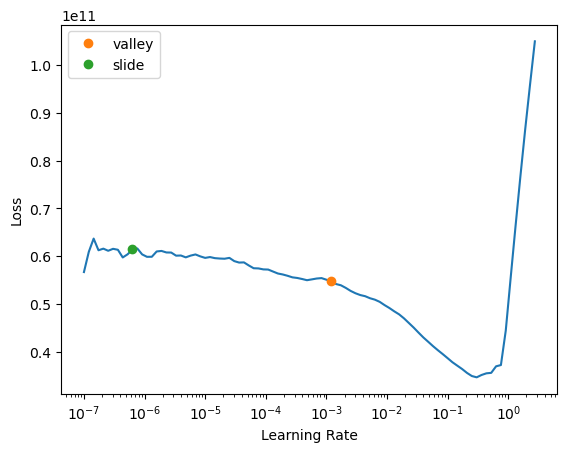

In [5]:
dls = fastai.TabularDataLoaders.from_df(df,procs=[fastai.Normalize],cont_names=["floor", "floor_area_sqm", "lease_commence_date", "date", "lat","long"],y_names=["resale_price"])
#dls.show_batch()
def MSE(yhat,y):
  return torch.mean(torch.square(yhat-y))
def RMSE(yhat,y):
  return torch.sqrt(MSE(yhat,y))
learn = fastai.tabular_learner(dls,y_range=(df.resale_price.min()*0.95, df.resale_price.max()*1.05),loss_func=MSE,metrics=RMSE)
learn.lr_find(suggest_funcs=(fastai.valley,fastai.slide))


In [9]:
learn = fastai.tabular_learner(
  dls,y_range=(df.resale_price.min()*0.95, df.resale_price.max()*1.05),
  loss_func=MSE,metrics=RMSE,
  cbs=[fastai.SaveModelCallback(),fastai.EarlyStoppingCallback(patience=5)]
)
learn.fit_one_cycle(100,5e-2)
learn.validate()


Better model found at epoch 0 with valid_loss value: 28433.62109375.


(#2) [813834688.0,28433.62109375]

In [10]:
# predict prices on map
row = df.drop(['resale_price'], axis=1).iloc[0].copy()
cats = ['floor', 'floor_area_sqm', 'lease_commence_date', 'date']
for cat in cats:
  row[cat] = df[cat].median()
latMin, latMax = df.lat.min(),df.lat.max()
latLeft = latMin - (latMax-latMin)/10
latRight = latMax + (latMax-latMin)/10
longMin, longMax = df.long.min(),df.long.max()
longLeft = longMin - (longMax-longMin)/10
longRight = longMax + (longMax-longMin)/10
n1 = 3*35
n2 = 3*35
longs = np.linspace(longLeft, longRight, n1)
lats = np.linspace(latLeft, latRight, n2)
prices = np.ndarray((n2,n1))
for i,lat in enumerate(lats):
  if i%10==0: print(f"{i} of {n2}") 
  row['lat'] = lat
  for j,long in enumerate(longs):
    row['long'] = long
    with learn.no_bar(), learn.no_logging():
      _, yPred, _ = learn.predict(row)
      prices[i][j] = yPred.item()
print('done!')

0 of 105
10 of 105
20 of 105
30 of 105
40 of 105
50 of 105
60 of 105
70 of 105
80 of 105
90 of 105
100 of 105
done!


In [11]:
import http.client, urllib.parse
import json

mrts = ["Sengkang MRT", "Punggol MRT"]
longLats = load_pkl()

responses = []
for mrt in mrts:
	conn = http.client.HTTPConnection('api.positionstack.com')
	params = urllib.parse.urlencode({
		'access_key': key,
		'query': mrt[:-4] + ' Station',
		'region': 'Singapore',
		'limit': 1,
	})
	conn.request('GET', '/v1/forward?{}'.format(params))
	res = conn.getresponse()
	data = res.read()
	dataList = json.loads(data.decode('utf-8'))['data']
	if (len(dataList)==0): 
		print(f"check {add}. No data returned")
		count += 1
		errors.append(add)
		continue
	first_response = dataList[0]
	responses.append(first_response)
	if (first_response['confidence'] > 0.9) and (first_response['country']=='Singapore'):
		longLats[f"{mrt}"] = (first_response['longitude'], first_response['latitude'])
		print(f"{first_response['label']}, confidence {first_response['confidence']}")
	else:
		print(f"check {mrt}. {first_response['label']}. confidence of {first_response['confidence']}")

dump_pkl(longLats)


longLats loaded. 7172
Sengkang Station, Singapore, confidence 1
Punggol Station, Singapore, confidence 1
pickle dumped. 7173


In [54]:
longLats['Kallang MRT'] = (103.87142, 1.31117)
dump_pkl(longLats)

pickle dumped. 6351


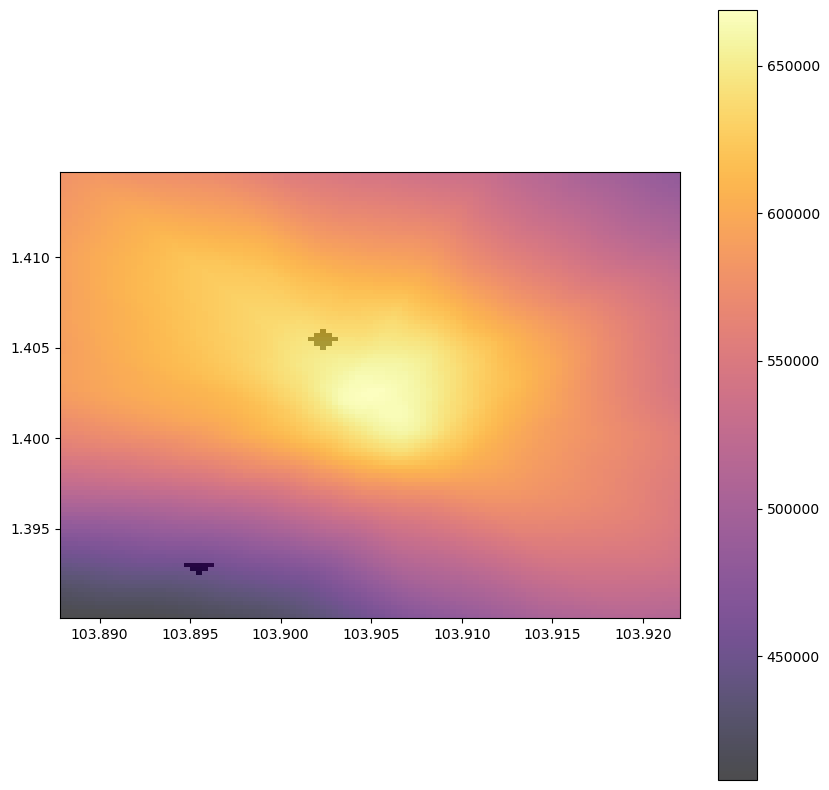

In [15]:
def min_coords(long,lat):
  return (np.abs((longs-long)).argmin(), np.abs(lats-lat).argmin())
def map_left(i,j):
  mrt_map[j-2][i+1]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j+1][i]=1
  mrt_map[j+1][i+1]=1
  mrt_map[j+2][i+1]=1
def map_sq(i,j):
  mrt_map[j-1][i-1]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j+1][i]=1
  mrt_map[j+1][i+1]=1
  mrt_map[j+1][i-1]=1
def map_right(i,j):
  mrt_map[j-2][i-1]=1
  mrt_map[j-1][i-1]=1
  mrt_map[j-1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j+1][i]=1
  mrt_map[j+1][i-1]=1
  mrt_map[j+2][i-1]=1
def map_up(i,j):
  mrt_map[j+1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j-1][i-2]=1
  mrt_map[j-1][i-1]=1
  mrt_map[j-1][i+2]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i]=1
def map_down(i,j):
  mrt_map[j-1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j+1][i-2]=1
  mrt_map[j+1][i-1]=1
  mrt_map[j+1][i+2]=1
  mrt_map[j+1][i+1]=1
  mrt_map[j+1][i]=1
def map_star(i,j):
  mrt_map[j+1][i]=1
  mrt_map[j+1][i-1]=1
  mrt_map[j+1][i+1]=1
  mrt_map[j-1][i]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i-1]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j][i-2]=1
  mrt_map[j][i+2]=1
  mrt_map[j+2][i]=1
  mrt_map[j-2][i]=1
mrt_map = np.zeros((n2,n1))

mrts = ["Sengkang MRT", "Punggol MRT"]
map_down(*min_coords(*longLats[mrts[0]]))
map_star(*min_coords(*longLats[mrts[1]]))
#map_left(*min_coords(*longLats[mrts[2]]))
#map_right(*min_coords(*longLats[mrts[3]]))
#map_right(*min_coords(*longLats[mrts[4]]))
#map_star(*min_coords(*longLats[mrts[5]]))

fig,ax=plt.subplots()
#mrt
#color map
shw2 = ax.imshow(mrt_map, extent=[longLeft, longRight, latLeft, latRight], origin='lower',cmap='Greys',alpha=1.0)
shw = ax.imshow(prices, extent=[longLeft, longRight, latLeft, latRight], origin='lower',alpha=0.7, cmap='inferno')
bar = plt.colorbar(shw)
fig.set_figwidth(10)
fig.set_figheight(10/n1*n2)

plt.show()

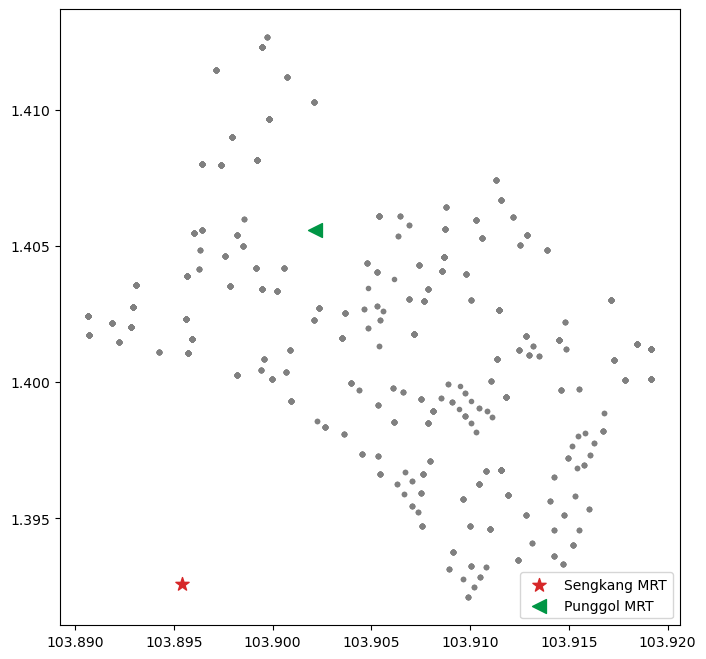

In [17]:
circle = "#FA9E0D"
ew = "#009645"
dt = "#005EC4"
red = '#d62728'
ne = '#9900AA'
markers = ["*", '<', "<", '<', '<', '*', '^']
colors = [red,ew,ew,ew,ew,red]

fig,ax2=plt.subplots()
ax2.scatter(df.long,df.lat,marker='.',c="gray")

for i,mrt in enumerate(mrts):
  ax2.scatter([longLats[mrt][0]], [longLats[mrt][1]],marker=markers[i],c=colors[i],label=mrt,s=100)
ax2.legend(loc='lower right')
fig.set_figwidth(8)
fig.set_figheight(8/n1*n2)

plt.show()

for mrt in mrts:
  (i,j) = min_coords(*longLats[mrt])
